In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import gc 
gc.collect()

0

In [3]:
df = pd.read_csv("data/modelado/ds_modelado.csv")

In [4]:
import pandas as pd

# 🕒 Crear columna de timestamp (ya que lo usamos para ordenar)
df['timestamp_intervalo'] = pd.to_datetime(
    df.rename(columns={
        'año_intervalo': 'year',
        'mes_intervalo': 'month',
        'dia_intervalo': 'day',
        'hora_intervalo': 'hour'
    })[['year', 'month', 'day', 'hour']]
)

# ===============================
# 🚀 Feature Engineering SIN data leakage
# ===============================

# Ordenar el dataframe por usuario y tiempo
df = df.sort_values(['id_usuario', 'timestamp_intervalo'])

# 1️⃣ Rolling stats por estación de origen (media duración últimos 3 viajes)
df['duracion_rolling_3'] = (
    df.sort_values(['id_estacion_origen', 'timestamp_intervalo'])
      .groupby('id_estacion_origen')['duracion_recorrido']
      .apply(lambda x: x.shift().rolling(window=3, min_periods=1).mean())
      .reset_index(drop=True)
)

# 2️⃣ Salidas acumuladas por estación de origen (antes de ese viaje)
df['salidas_acumuladas_origen'] = (
    df.sort_values(['id_estacion_origen', 'timestamp_intervalo'])
      .groupby('id_estacion_origen')
      .cumcount()
)

# 3️⃣ Edad media en la estación de origen (hasta el momento anterior)
df['edad_media_origen'] = (
    df.sort_values(['id_estacion_origen', 'timestamp_intervalo'])
      .groupby('id_estacion_origen')['edad_usuario']
      .apply(lambda x: x.shift().expanding().mean())
      .reset_index(drop=True)
)

# 4️⃣ Proporción histórica de usuarios registrados por estación de origen
df['prop_usuarios_reg_origen'] = (
    df.sort_values(['id_estacion_origen', 'timestamp_intervalo'])
      .groupby('id_estacion_origen')['usuario_registrado']
      .apply(lambda x: x.shift().expanding().mean())
      .reset_index(drop=True)
)

In [5]:


# 5️⃣ Hora media histórica por estación de origen
df['hora_media_origen'] = (
    df.sort_values(['id_estacion_origen', 'timestamp_intervalo'])
      .groupby('id_estacion_origen')['hora_origen']
      .apply(lambda x: x.shift().expanding().mean())
      .reset_index(drop=True)
)

# 6️⃣ Salidas promedio acumuladas hasta ese momento (por estación y hora)
df['salidas_intervalo_acumuladas'] = (
    df.sort_values(['id_estacion_origen', 'timestamp_intervalo'])
      .groupby('id_estacion_origen')
      .cumcount()
)

from collections import defaultdict

usuarios_hist = defaultdict(set)
usuarios_unicos = []

for estacion, usuario in zip(df['id_estacion_origen'], df['id_usuario']):
    usuarios_unicos.append(len(usuarios_hist[estacion]))
    usuarios_hist[estacion].add(usuario)

df['usuarios_unicos_origen'] = usuarios_unicos

print("Recurrencia del usuario calculada.")

# 8️⃣ Recurrencia del usuario (cuántos viajes hizo antes)
df['recurrencia_usuario'] = (
    df.sort_values(['id_usuario', 'timestamp_intervalo'])
      .groupby('id_usuario')
      .cumcount()
)
# 9️⃣ Hora pico (solo en base a hora del viaje, sin leakage)
df['es_hora_pico'] = df['hora_origen'].apply(lambda h: int(7 <= h <= 10 or 17 <= h <= 20))

# 🔥 Eliminar columnas que sí generan leakage o ya no se usan
columnas_a_eliminar = [
    "N_salidas_intervalo",  # info del futuro
    'id_estacion_destino',
    'barrio_destino',
    'zona_destino_cluster',
    'cantidad_estaciones_cercanas_destino',
    'año_destino',
    'mes_destino',
    'dia_destino',
    'hora_destino',
    'minuto_destino',
    'segundo_destino',
    "id_recorrido",  # ID del target
    "duracion_recorrido",  # usada en rolling, ya no la necesitamos
    "timestamp_intervalo",  # usada solo para ordenar
]

# ✅ Guardar dataset final sin data leakage
modelado_final = df.drop(columns=columnas_a_eliminar).copy()
modelado_final.to_csv("data/modelado/ds_modelado_nuevo.csv", index=False)


Recurrencia del usuario calculada.


In [6]:
df = pd.read_csv("data/modelado/ds_modelado_nuevo.csv")
df = df[df["estacion_del_anio"] == 1].copy()

target = "N_arribos_intervalo"

df_train, df_val = train_test_split(
    df,
    test_size=0.2,
    stratify=df["año_intervalo"],
    random_state=42
)

In [7]:
features = [col for col in df.columns if col not in [target]]

In [8]:
print(modelado_final.columns)

Index(['id_estacion_origen', 'id_usuario', 'modelo_bicicleta', 'barrio_origen',
       'dia_semana', 'es_finde', 'estacion_del_anio', 'edad_usuario',
       'año_alta', 'mes_alta', 'genero_FEMALE', 'genero_MALE', 'genero_OTHER',
       'usuario_registrado', 'zona_origen_cluster',
       'cantidad_estaciones_cercanas_origen', 'N_arribos_intervalo',
       'año_origen', 'mes_origen', 'dia_origen', 'hora_origen',
       'minuto_origen', 'segundo_origen', 'año_intervalo', 'mes_intervalo',
       'dia_intervalo', 'hora_intervalo', 'minuto_intervalo',
       'duracion_rolling_3', 'salidas_acumuladas_origen', 'edad_media_origen',
       'prop_usuarios_reg_origen', 'hora_media_origen',
       'salidas_intervalo_acumuladas', 'usuarios_unicos_origen',
       'recurrencia_usuario', 'es_hora_pico'],
      dtype='object')


In [9]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(df_train[features])
X_val = scaler_X.transform(df_val[features])

y_train = scaler_y.fit_transform(df_train[[target]]).flatten()
y_val = scaler_y.transform(df_val[[target]]).flatten()

In [10]:

def evaluar_modelo(modelo, nombre):
    modelo.fit(X_train, y_train)
    y_pred_scaled = modelo.predict(X_val)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()
    
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"📊 {nombre}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    print("-" * 40)
    return modelo, mae, r2

In [11]:
modelos = {
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
    "Ridge": Ridge(alpha=1.0),
    "MLP": MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=100, early_stopping=True, random_state=42)
}

In [12]:
resultados = []

In [13]:
#Pruebo Random Forest
rf_model, rf_mae, rf_r2 = evaluar_modelo(modelos["Random Forest"], "Random Forest")
resultados.append(("Random Forest", rf_mae, rf_r2))

📊 Random Forest
MAE: 1.25
R²: 0.2238
----------------------------------------


In [8]:
#Pruebo Gradient Boosting
#gb_model, gb_mae, gb_r2 = evaluar_modelo(modelos["Gradient Boosting"], "Gradient Boosting")
#resultados.append(("Gradient Boosting", gb_mae, gb_r2))

In [17]:
#Pruebo Ridge
ridge_model, ridge_mae, ridge_r2 = evaluar_modelo(modelos["Ridge"], "Ridge")
resultados.append(("Ridge", ridge_mae, ridge_r2)) 

📊 Ridge
MAE: 1.37
R²: 0.0796
----------------------------------------


In [ ]:
#Pruebo MLP
#mlp_model, mlp_mae, mlp_r2 = evaluar_modelo(modelos["MLP"], "MLP")
#resultados.append(("MLP", mlp_mae, mlp_r2))

📊 MLP
MAE: 1.23
R²: 0.2332
----------------------------------------


In [ ]:
#df_resultados = pd.DataFrame(resultados, columns=["Modelo", "MAE", "R2"])
#df_resultados.sort_values("MAE", inplace=True)
#print(df_resultados)


  Modelo       MAE        R2
0    MLP  1.232353  0.233174


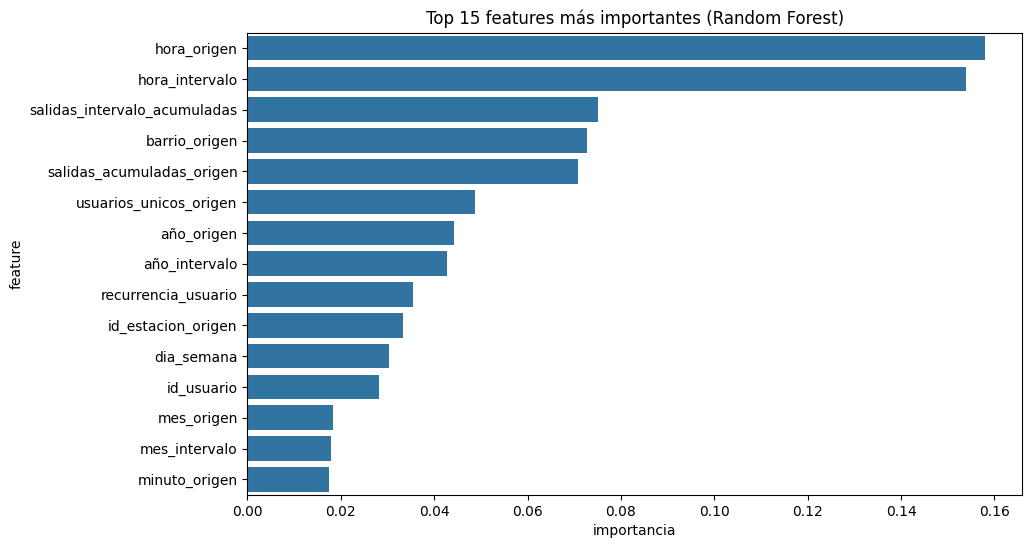

In [18]:

# %%
# 🔍 Importancia de features (solo si usaste RF o GB)
modelo_rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
modelo_rf.fit(X_train, y_train)

importancias = modelo_rf.feature_importances_
importancia_df = pd.DataFrame({
    "feature": features,
    "importancia": importancias
}).sort_values(by="importancia", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importancia_df.head(15), x="importancia", y="feature")
plt.title("Top 15 features más importantes (Random Forest)")
plt.show()

In [ ]:
# 1. 📥 Importaciones
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 2. 📄 Cargar dataset y limpiar
df = pd.read_csv("data/modelado/ds_modelado.csv")
df = df[df["estacion_del_anio"] == 1].copy()  # verano

target = "N_arribos_intervalo"
cols_a_excluir = [
    "N_arribos_intervalo", "id_recorrido", "id_usuario",
    "id_estacion_destino", "barrio_destino", "zona_destino_cluster",
    "cantidad_estaciones_cercanas_destino",
    "año_destino", "mes_destino", "dia_destino",
    "hora_destino", "minuto_destino", "segundo_destino",
    "duracion_recorrido"
]
features = [col for col in df.columns if col not in cols_a_excluir]

# 3. 🔀 Split estratificado por año
df_train, df_val = train_test_split(
    df, test_size=0.2, stratify=df["año_intervalo"], random_state=42
)

# 4. ⚙️ Lags
def crear_features_con_lags(X, y, ventana=6):
    X_seq, y_seq = [], []
    for i in range(ventana, len(X)):
        X_seq.append(X[i-ventana:i].flatten())
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# 5. 🧼 Escalar
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(df_train[features])
X_val_scaled = scaler_X.transform(df_val[features])

y_train = df_train[target].values
y_val = df_val[target].values

ventana = 6
X_train_lag, y_train_lag = crear_features_con_lags(X_train_scaled, y_train, ventana)
X_val_lag, y_val_lag = crear_features_con_lags(X_val_scaled, y_val, ventana)

# 6. 📈 Comparar modelos
def evaluar_modelo(modelo, nombre):
    modelo.fit(X_train_lag, y_train_lag)
    y_pred = modelo.predict(X_val_lag)
    mae = mean_absolute_error(y_val_lag, y_pred)
    r2 = r2_score(y_val_lag, y_pred)
    print(f"📊 {nombre}\nMAE: {mae:.2f}\nR²: {r2:.4f}\n" + "-"*40)
    return modelo, mae, r2

modelos = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42),
}

resultados = []
for nombre, modelo in modelos.items():
    m, mae, r2 = evaluar_modelo(modelo, nombre)
    resultados.append((nombre, mae, r2))

# 7. 🔍 Grid Search Gradient Boosting
gb_params = {
    "n_estimators": [50, 100],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0]
}

gb = GradientBoostingRegressor(random_state=42)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
y_strat = pd.qcut(y_train_lag, q=5, labels=False)

grid = GridSearchCV(gb, gb_params, cv=cv, scoring="r2", n_jobs=-1, verbose=2)
grid.fit(X_train_lag, y_train_lag, groups=y_strat)

print("🏆 Mejor combinación de hiperparámetros:")
print(grid.best_params_)

y_pred = grid.best_estimator_.predict(X_val_lag)
mae = mean_absolute_error(y_val_lag, y_pred)
r2 = r2_score(y_val_lag, y_pred)
print(f"Gradient Boosting GridSearch\nMAE: {mae:.2f}\nR²: {r2:.4f}")

resultados.append(("Gradient Boosting (GS)", mae, r2))

# 8. 📊 Comparación
df_resultados = pd.DataFrame(resultados, columns=["Modelo", "MAE", "R²"])
sns.barplot(data=df_resultados, y="Modelo", x="R²", palette="viridis")
plt.title("Comparación de modelos - R²")
plt.show()
